# How good is my Kriging model? - tests with IDW algorithm - tutorial

## Table of Contents:

1. Read point data,
2. Divide dataset into two sets: modeling and validation set,
3. Perform IDW and evaluate it,
4. Perform variogram modeling on the modeling set,
5. Validate Kriging and compare Kriging and IDW validation results,
6. Bonus scenario: only 2% of values are known!

## Level: Basic

## Changelog

| Date | Change description                                                                                                    | Author |
|------|-----------------------------------------------------------------------------------------------------------------------|--------|
| 2022-08-23 | The new version of tutorial for the 0.3.0 version of a package                                                        | @SimonMolinsky |
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function                                                               | @SimonMolinsky |
| 2021-12-08 | Behavior of `prepare_kriging_data()` function has changed                                                             | @SimonMolinsky |
| 2021-05-12 | First version of tutorial                                                                                             | @SimonMolinsky |

## Introduction

In this tutorial, we will learn how we could validate our Kriging model. We'll compare it to the **Inverse Distance Weighting** function, where the unknown point value is interpolated as the weighted mean of its neighbors. Weights are inversely proportional to the distance between neighboring points, dropping faster with a higher power.

(1) **GENERAL FORM OF IDW**

$$z(u) = \frac{\sum_{i}\lambda_{i}*z_{i}}{\sum_{i}\lambda_{i}}$$

where:

- $z(u)$: is the value at an unknown location,
- $i$: is an i-th known location,
- $z_{i}$: is a value at known location $i$,
- $\lambda_{i}$: is a weight assigned to the known location $i$.

(2) **WEIGHTING PARAMETER**

$$\lambda_{i} = \frac{1}{d^{p}_{i}}$$

where:

- $d$:  is a distance from the known point $z_{i}$ to the unknown point $z(u)$,
- $p$: is a hyperparameter that controls how strong a relationship is between a known and unknown point. You may set large $p$ if you want to show a strong relationship between the closest point and the feeble influence of distant points. On the other hand, you may set small $p$ to emphasize that points are influencing each other with the same power regardless of their distance.

---

As you noticed **IDW** is a simple but powerful technique. Unfortunately, it has a significant drawback: **we must set `p` - power - manually**, which isn't derived from the data and variogram. That's why it can be used for other tasks. An example is to use IDW as a baseline for comparison to the different techniques.

## Import packages

In [1]:
import numpy as np

from pyinterpolate.idw.idw import inverse_distance_weighting  # function for idw
from pyinterpolate.io.read_data import read_txt
from pyinterpolate.variogram import build_experimental_variogram  # experimental semivariogram
from pyinterpolate.variogram import build_theoretical_variogram  # theoretical models
from pyinterpolate.kriging.point_kriging import kriging  # kriging models

## 1) Read point data

In [2]:
dem = read_txt('samples/point_data/txt/pl_dem_epsg2180.txt')
dem

array([[2.37685325e+05, 5.45416708e+05, 5.12545509e+01],
       [2.37674140e+05, 5.45209671e+05, 4.89582825e+01],
       [2.37449255e+05, 5.41045935e+05, 1.68178635e+01],
       ...,
       [2.54751735e+05, 5.41480271e+05, 4.03093376e+01],
       [2.54682103e+05, 5.40099921e+05, 2.19432678e+01],
       [2.54521994e+05, 5.36925123e+05, 5.15251350e+01]])

## 2) Divide the dataset into two sets: modeling and validation set

In this step, we will divide our dataset into two sets:

- modeling set (10%): points used for variogram modeling,
- validation set (90%): points used for prediction and results validation.

The baseline dataset will be divided randomly.

In [3]:
# Create modeling and validation sets

def create_model_validation_sets(dataset: np.array, frac=0.5, rnd_seed=101):

    np.random.seed(rnd_seed)

    removed_idx = np.random.randint(0, len(dataset)-1, size=int(frac * len(dataset)))
    validation_set = dataset[removed_idx]
    modeling_set = np.delete(dataset, removed_idx, 0)
    return modeling_set, validation_set

known_points, unknown_points = create_model_validation_sets(dem)

## 3) Perform IDW and evaluate it

Inverse Distance Weighting doesn't require variogram modeling or other steps. We pass power that affects weights in a denominator. Things to remember are:

- Large `power` -> closer neighbours are more important,
- `power` which is close to the **zero** -> all neighbors are important, and we assume that the distant process has the same effect on our variable as the closest events.


In [4]:
IDW_POWER = 2
NUMBER_OF_NEIGHBOURS = 128

idw_predictions = []

for pt in unknown_points:
    idw_result = inverse_distance_weighting(known_points, pt[:-1], NUMBER_OF_NEIGHBOURS, IDW_POWER)
    idw_predictions.append(idw_result)

In [5]:
# Evaluation

idw_rmse = np.mean(np.sqrt((unknown_points[:, -1] - np.array(idw_predictions))**2))
print(f'Root Mean Squared Error of prediction with IDW is {idw_rmse}')

Root Mean Squared Error of prediction with IDW is 2.3249238383477264


**Clarification:** Obtained Root Mean Squared Error could serve as a baseline for further model development. To build a better reference, we create four IDW models of powers:

1. **0.5**
2. **1**
3. **2**
4. **4**

In [6]:
IDW_POWERS = [0.5, 1, 2, 4]
idw_rmse = {}

for pw in IDW_POWERS:
    results = []
    for pt in unknown_points:
        idw_result = inverse_distance_weighting(known_points, pt[:-1], NUMBER_OF_NEIGHBOURS, pw)
        results.append(idw_result)
    idw_rmse[pw] = np.mean(np.sqrt((unknown_points[:, -1] - np.array(results))**2))

In [7]:
for pw in IDW_POWERS:
    print(f'Root Mean Squared Error of prediction with IDW of power {pw} is {idw_rmse[pw]:.4f}')

Root Mean Squared Error of prediction with IDW of power 0.5 is 4.1013
Root Mean Squared Error of prediction with IDW of power 1 is 3.5778
Root Mean Squared Error of prediction with IDW of power 2 is 2.3249
Root Mean Squared Error of prediction with IDW of power 4 is 1.7020


## 4) Perform variogram modeling on the modeling set

In this step, we will go through semivariogram modeling for Kriging interpolation.

In [8]:
max_range = 10000
step_size = 500

exp_semivar = build_experimental_variogram(known_points, step_size=step_size, max_range=max_range)

In [9]:
semivar = build_theoretical_variogram(exp_semivar, model_type='circular', sill=exp_semivar.variance, rang=max_range)

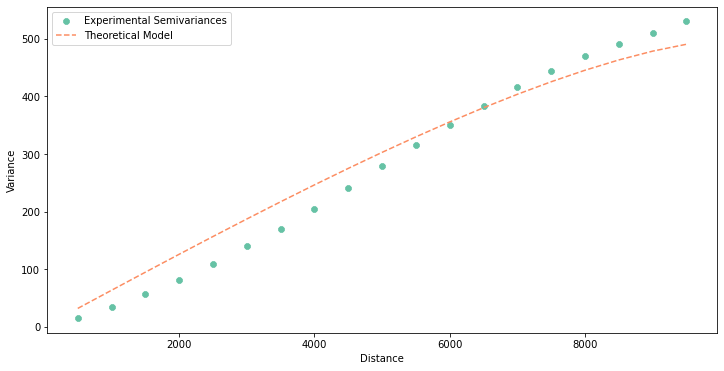

In [10]:
semivar.plot()

## 5) Validate Kriging and compare Kriging and IDW validation results

Lastly, we perform Kriging interpolation and compare results to the **IDW** models. We use all points to weight values at unknown locations and the semivariogram model we chose in the previous step.

In [11]:
# Set Kriging model

predictions = kriging(observations=known_points, theoretical_model=semivar, points=unknown_points[:, :-1], no_neighbors=128)

100%|██████████| 3446/3446 [01:46<00:00, 32.24it/s] 


In [12]:
# Evaluation

kriging_rmse = np.mean(np.sqrt((unknown_points[:, -1] - np.array(predictions[:, 0]))**2))
print(f'Root Mean Squared Error of prediction with Kriging is {kriging_rmse}')

Root Mean Squared Error of prediction with Kriging is 1.5443489790592477


**Clarification**: Kriging is better than any of the IDW models, and we may assume that our modeling approach gives us more insights into the spatial process we are observing. But this is not the end. Let's consider a more complex scenario!

## 6) Bonus scenario: only 2% of values are known!

Data sampled from the real world is rarely as good as the sample from the tutorial. It is too expensive to densely sample every location, and usually, we get only a tiny percent of the area covered by data. That's why it is good to compare **IDW vs. Kriging** in this scenario! We repeat steps 1-5 with a change in the division for the modeling/validation set. (I encourage you to try it alone and compare your code and results with those given in this notebook).

In [13]:
# Data preparation

known_points, unknown_points = create_model_validation_sets(dem, 0.98, rnd_seed=111)

In [14]:
IDW_POWERS = [0.5, 1, 2, 4]
idw_rmse = {}

for pw in IDW_POWERS:
    results = []
    for pt in unknown_points:
        idw_result = inverse_distance_weighting(known_points, pt[:-1], NUMBER_OF_NEIGHBOURS, pw)
        results.append(idw_result)
    idw_rmse[pw] = np.mean(np.sqrt((unknown_points[:, -1] - np.array(results))**2))

In [15]:
for pw in IDW_POWERS:
    print(f'Root Mean Squared Error of prediction with IDW of power {pw} is {idw_rmse[pw]:.4f}')

Root Mean Squared Error of prediction with IDW of power 0.5 is 5.0498
Root Mean Squared Error of prediction with IDW of power 1 is 4.3609
Root Mean Squared Error of prediction with IDW of power 2 is 2.7773
Root Mean Squared Error of prediction with IDW of power 4 is 2.0612


In [16]:
# Variogram

max_range = 10000
step_size = 500

exp_semivar = build_experimental_variogram(known_points, step_size=step_size, max_range=max_range)

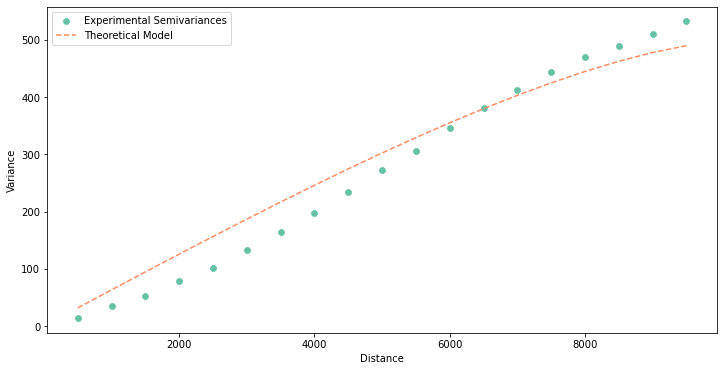

In [17]:
semivar = build_theoretical_variogram(exp_semivar, model_type='circular', sill=exp_semivar.variance, rang=max_range)
semivar.plot()

In [18]:
# Set Kriging model

predictions = kriging(observations=known_points, theoretical_model=semivar, points=unknown_points[:, :-1], no_neighbors=128)

100%|██████████| 6755/6755 [02:22<00:00, 47.33it/s] 


In [19]:
# Evaluation

kriging_rmse = np.mean(np.sqrt((unknown_points[:, -1] - np.array(predictions[:, 0]))**2))
print(f'Root Mean Squared Error of prediction with Kriging is {kriging_rmse}')

Root Mean Squared Error of prediction with Kriging is 1.8816494169566806


In [20]:
# Comparison

for pw in IDW_POWERS:
    print(f'Root Mean Squared Error of prediction with IDW of power {pw} is {idw_rmse[pw]:.4f}')
print(f'Root Mean Squared Error of prediction with Kriging is {kriging_rmse:.4f}')

Root Mean Squared Error of prediction with IDW of power 0.5 is 5.0498
Root Mean Squared Error of prediction with IDW of power 1 is 4.3609
Root Mean Squared Error of prediction with IDW of power 2 is 2.7773
Root Mean Squared Error of prediction with IDW of power 4 is 2.0612
Root Mean Squared Error of prediction with Kriging is 1.8816


Your results may be different (if you set another random seed), but in most cases, Kriging will be better than IDW. Even more important is that for the single data source with a low number of samples, we don't have the opportunity to perform the validation step, and we're unable to guess how big the power parameter should be. With Kriging, we model variogram, and _voila!_ - model works.

---

## Where to go?

### Next steps:

* [Blocks to points Ordinary Kriging interpolation]()
* [Semivariogram Regularization]()

### Additional materials:

* [Ordinary and Simple Kriging]()
* [Outliers and Their Influence on the Final Model]()